# From Neural Variability to Population Coding

## Import

In [1]:
import os

import numpy as np
import pandas as pd
import scipy.stats as st
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
# Brain Observatory Setup 
from allensdk.brain_observatory.drifting_gratings import DriftingGratings
from allensdk.core.brain_observatory_cache import BrainObservatoryCache

manifest_file = '../data/allen-brain-observatory/visual-coding-2p/manifest.json'
boc = BrainObservatoryCache(manifest_file=manifest_file)

## Tuning curve for the drifting grating stimulus

In [3]:
cell_id = 541513979

# get the experiment session where this cell has the drifting grating stimulus
exps = boc.get_ophys_experiments(cell_specimen_ids=[cell_id], stimuli=['drifting_gratings'])
session_id = exps[0]['id']
data_set = boc.get_ophys_experiment_data(session_id)

# get dff traces
timestamps, dff = data_set.get_dff_traces()
cell_index = data_set.get_cell_specimen_indices([cell_id])[0]
dff_trace = dff[cell_index,:]

In [4]:
# get the stimulus table for the drifting grating stimulus
stim_table = data_set.get_stimulus_table('drifting_gratings')
stim_table.head()

,temporal_frequency,orientation,blank_sweep,start,end
0,1.0,45.0,0.0,736,796
1,15.0,90.0,0.0,826,886
2,1.0,270.0,0.0,917,977
3,NaN,NaN,1.0,1007,1067
4,4.0,90.0,0.0,1098,1158


In [5]:
# create a pandas DataFrame to hold the response of the neuron in each trial
response = pd.DataFrame(
    columns=('orientation', 'temporal_frequency', 'trial_response'), 
    index=stim_table.index.values
) 
response['orientation'] = stim_table.orientation
response['temporal_frequency'] = stim_table.temporal_frequency
for ind,row_stim in stim_table.iterrows():
    # mean DF/F during the grating presentation
    response.loc[ind, 'trial_response'] = dff_trace[int(row_stim.start):int(row_stim.end)].mean()

Text(0, 0.5, 'Mean DF/F')

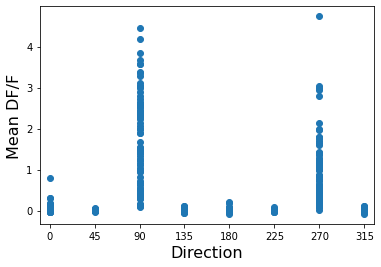

In [6]:
# plot grating response as a function of the grating orientation
plt.plot(response.orientation.values, response.trial_response.values, 'o')
plt.xticks(range(0,360,45))
plt.xlim(-10,325)
plt.xlabel("Direction", fontsize=16)
plt.ylabel("Mean DF/F", fontsize=16)

[  0.  45.  90. 135. 180. 225. 270. 315.]


Text(0, 0.5, 'Mean response (DFF)')

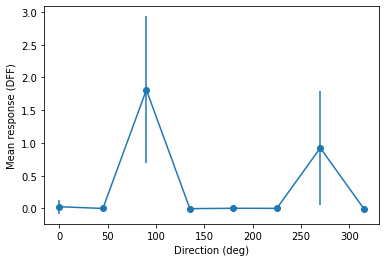

In [7]:
# tuning curve
all_ori = np.sort(stim_table.orientation.unique())
orivals = all_ori[np.isfinite(all_ori)]
print(orivals)

# compute
tuning = np.empty((8))
tuning_std = np.empty((8))
for i, ori in enumerate(orivals):
    trials = response[response.orientation==ori]
    tuning[i] = trials.trial_response.mean()
    tuning_std[i] = trials.trial_response.std()
    

# plot
# plt.plot(orivals, tuning, 'o-')
plt.errorbar(orivals, tuning, yerr=tuning_std, fmt='o-')
plt.xlabel("Direction (deg)")
plt.ylabel("Mean response (DFF)")

## Can we decode stimulus direction on a trial-to-trial basis by looking at the responses of this neuron?

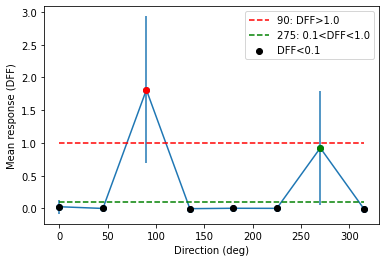

In [8]:
# decode with tuning curves
plt.errorbar(orivals, tuning, yerr=tuning_std, fmt='o-', zorder=0)
plt.xlabel("Direction (deg)")
plt.ylabel("Mean response (DFF)")

plt.scatter(orivals[2], tuning[2], color='r')
plt.hlines([1.0], 0,315, ls='--', color='r', 
           label='90: DFF>1.0', zorder=15)
plt.scatter(orivals[6], tuning[6], color='g')
plt.hlines([0.1], 0,315, ls='--', color='g', 
           label='275: 0.1<DFF<1.0', zorder=10)

plt.scatter(orivals[[0,1,3,4,5,7]], tuning[[0,1,3,4,5,7]], color='k',
            label='DFF<0.1', zorder=5)
plt.legend()

[Discuss] What are some issues with this heuristic approach of using tuning curve for decoding stimulus direction?

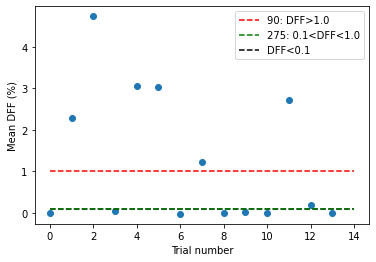

In [9]:
# Plot the trial_response for the first 15 trials
plt.plot(response.trial_response[:14], 'o')

plt.hlines([1.0], 0,14, ls='--', color='r', 
           label='90: DFF>1.0', zorder=15)
plt.hlines([0.1], 0,14, ls='--', color='g', 
           label='275: 0.1<DFF<1.0', zorder=10)
plt.hlines([0.1], 0,14, ls='--', color='k', 
           label='DFF<0.1', zorder=5)

plt.xlabel("Trial number")
plt.ylabel("Mean DFF (%)")
plt.legend()

In [10]:
# heuristic decoding using cell1 tuning profile
import random

ori_heuristic_cell1 = []
for trial_response in response.trial_response:
    if trial_response >= 1.0:
        ori_heuristic_cell1.append(90)
    elif (trial_response < 1.0 and trial_response>=0.1):
        ori_heuristic_cell1.append(270)
    else:
        ori_heuristic_cell1.append(random.choice([0, 45, 135, 180, 225, 315]))


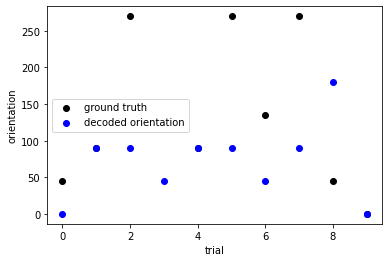

In [11]:
# deviation from ground truth
plt.scatter(np.arange(10), stim_table.orientation[:10], color='k',
         label='ground truth')
plt.scatter(np.arange(10), ori_heuristic_cell1[:10], color='b', 
            label='decoded orientation')
plt.xlabel('trial')
plt.ylabel('orientation')
plt.legend()

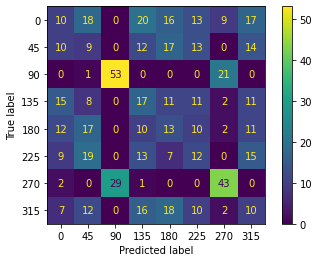

In [12]:
# confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(stim_table.orientation.fillna(0).astype(int), ori_heuristic_cell1)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, 
                              display_labels=np.arange(0, 360, 45))
disp.plot()

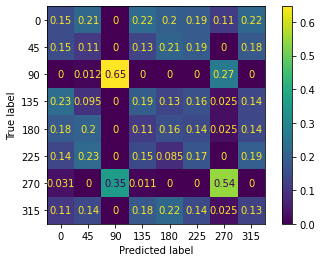

In [13]:
# normalized confusion matrix
normalized_cm = cm/ np.sum(cm, axis=0)
disp = ConfusionMatrixDisplay(confusion_matrix=normalized_cm, 
                              display_labels=np.arange(0, 360, 45))
disp.plot()

[Discuss] What does the above confusion matrix tell us how good we are at decoding stimulus orienation? Are there particular orientations that we can decode better? Why? And why can't we decode other orientations equally well? Even for the orientations that we have decent decodability, why doesn't it approach 100%?

### Why are our guesses so deviated from the ground truth? What does it tell us about single neural responses and coding?
- variability in neural response
- ambiguity due to selectivity of neural response

## Other stimulus features can contribute to neural variability

In [14]:
# temporal frequencies
tfvals = np.sort(stim_table.temporal_frequency.unique())
tfvals = tfvals[np.isfinite(tfvals)]

tuning_array = np.empty((8,5))
for i,tf in enumerate(tfvals):
    for j,ori in enumerate(orivals):
        trials = response[(response.orientation==ori)&(response.temporal_frequency==tf)]
        tuning_array[j,i] = trials.trial_response.mean()

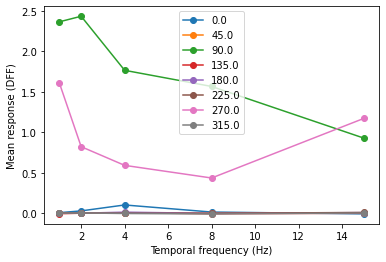

In [15]:
# for i in range(5):
#     plt.plot(orivals, tuning_array[:,i], 'o-', label=tfvals[i])
# plt.xlabel("Direction (deg)")
# plt.ylabel("Mean response (DFF)")
# plt.legend()

for i in range(8):
    plt.plot(tfvals, tuning_array[i,:], 'o-', label=orivals[i])
plt.xlabel("Temporal frequency (Hz)")
plt.ylabel("Mean response (DFF)")
plt.legend()

Text(0, 0.5, 'Mean response (DFF)')

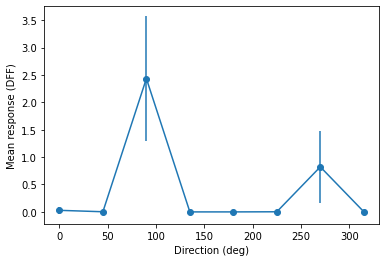

In [16]:
# conditioning on temporal_frequency=2.0
response_tf2 = response[response.temporal_frequency==2.0]

# compute
tuning_tf2 = np.empty((8))
tuning_std_tf2 = np.empty((8))
for i, ori in enumerate(orivals):
    trials_tf2 = response_tf2[response_tf2.orientation==ori]
    tuning_tf2[i] = trials_tf2.trial_response.mean()
    tuning_std_tf2[i] = trials_tf2.trial_response.std()
    

# plot
# plt.plot(orivals, tuning, 'o-')
plt.errorbar(orivals, tuning_tf2, yerr=tuning_std_tf2, fmt='o-')
plt.xlabel("Direction (deg)")
plt.ylabel("Mean response (DFF)")

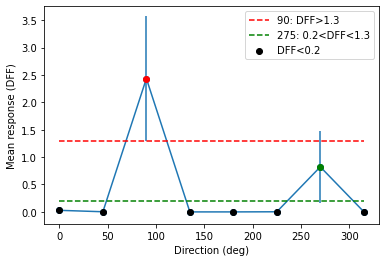

In [17]:
# decode with tuning curves
plt.errorbar(orivals, tuning_tf2, yerr=tuning_std_tf2, fmt='o-', zorder=0)
plt.xlabel("Direction (deg)")
plt.ylabel("Mean response (DFF)")

plt.scatter(orivals[2], tuning_tf2[2], color='r')
plt.hlines([1.3], 0,315, ls='--', color='r', 
           label='90: DFF>1.3', zorder=15)
plt.scatter(orivals[6], tuning_tf2[6], color='g')
plt.hlines([0.2], 0,315, ls='--', color='g', 
           label='275: 0.2<DFF<1.3', zorder=10)

plt.scatter(orivals[[0,1,3,4,5,7]], tuning_tf2[[0,1,3,4,5,7]], color='k',
            label='DFF<0.2', zorder=5)
plt.legend()

In [18]:
# heuristic decoding using cell1 tuning profile
import random

ori_heuristic_cell1_tf2 = []
for trial_response in response_tf2.trial_response:
    if trial_response >= 1.3:
        ori_heuristic_cell1_tf2.append(90)
    elif (trial_response < 1.3 and trial_response>=0.2):
        ori_heuristic_cell1_tf2.append(270)
    else:
        ori_heuristic_cell1_tf2.append(random.choice([0, 45, 135, 180, 225, 315]))


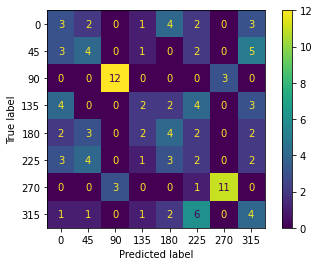

In [19]:
# confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(stim_table[stim_table.temporal_frequency==2.0].orientation.fillna(0).astype(int), ori_heuristic_cell1_tf2)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, 
                              display_labels=np.arange(0, 360, 45))
disp.plot()

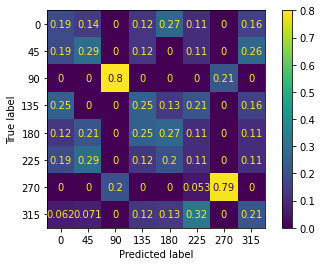

In [20]:
# normalized confusion matrix
normalized_cm = cm/ np.sum(cm, axis=0)
disp = ConfusionMatrixDisplay(confusion_matrix=normalized_cm, 
                              display_labels=np.arange(0, 360, 45))
disp.plot()

[Discuss] Compare this confusion matrix with the previous one without specifying temporal frequency. What's the difference? Which one gives better decodability of direction? What does this tell us?

### How can we do better at decoding the stimulus direction from neural responses?

### Let's see what happen when we have access to another neuron

In [25]:
cell2_id = 541513083
cell2_index = data_set.get_cell_specimen_indices([cell2_id])[0]

dff_trace2 = dff[cell2_index,:]


# create a pandas DataFrame to hold the response of the neuron in each trial
response2 = pd.DataFrame(
    columns=('orientation', 'temporal_frequency', 'trial_response'), 
    index=stim_table.index.values
) 
response2['orientation'] = stim_table.orientation
response2['temporal_frequency'] = stim_table.temporal_frequency
for ind,row_stim in stim_table.iterrows():
    # mean DF/F during the grating presentation
    response2.loc[ind, 'trial_response'] = dff_trace2[int(row_stim.start):int(row_stim.end)].mean()

Text(0, 0.5, 'Mean DF/F')

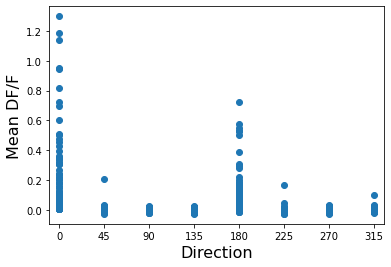

In [26]:
# plot grating response as a function of the grating orientation
plt.plot(response2.orientation.values, response2.trial_response.values, 'o')
plt.xticks(range(0,360,45))
plt.xlim(-10,325)
plt.xlabel("Direction", fontsize=16)
plt.ylabel("Mean DF/F", fontsize=16)

Text(0, 0.5, 'Mean response (DFF)')

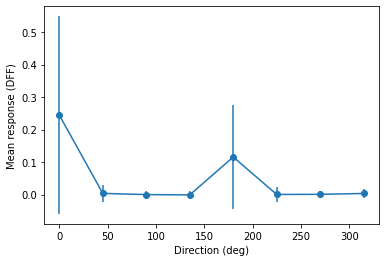

In [31]:
# tuning curve

# compute
tuning2 = np.empty((8))
tuning2_std = np.empty((8))
for i, ori in enumerate(orivals):
    trials2 = response2[response2.orientation==ori]
    tuning2[i] = trials2.trial_response.mean()
    tuning_std2[i] = trials2.trial_response.std()
    

# plot
# plt.plot(orivals, tuning2, 'o-')
plt.errorbar(orivals, tuning2, yerr=tuning_std2, fmt='o-')
plt.xlabel("Direction (deg)")
plt.ylabel("Mean response (DFF)")

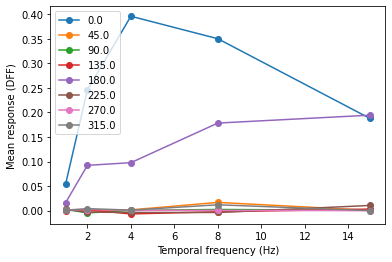

In [29]:
tuning_array2 = np.empty((8,5))
for i,tf in enumerate(tfvals):
    for j,ori in enumerate(orivals):
        trials2 = response2[(response2.orientation==ori)&(response2.temporal_frequency==tf)]
        tuning_array2[j,i] = trials2.trial_response.mean()

for i in range(8):
    plt.plot(tfvals, tuning_array2[i,:], 'o-', label=orivals[i])
plt.xlabel("Temporal frequency (Hz)")
plt.ylabel("Mean response (DFF)")
plt.legend()

Text(0, 0.5, 'Mean response (DFF)')

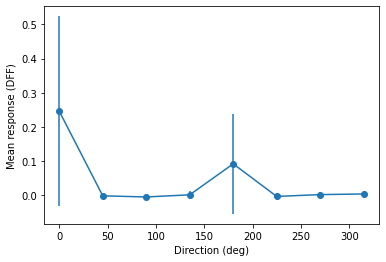

In [30]:
# conditioning on temporal_frequency=2.0
response2_tf2 = response2[response2.temporal_frequency==2.0]

# compute
tuning2_tf2 = np.empty((8))
tuning2_std_tf2 = np.empty((8))
for i, ori in enumerate(orivals):
    trials2_tf2 = response2_tf2[response2_tf2.orientation==ori]
    tuning2_tf2[i] = trials2_tf2.trial_response.mean()
    tuning2_std_tf2[i] = trials2_tf2.trial_response.std()
    

# plot
# plt.plot(orivals, tuning, 'o-')
plt.errorbar(orivals, tuning2_tf2, yerr=tuning2_std_tf2, fmt='o-')
plt.xlabel("Direction (deg)")
plt.ylabel("Mean response (DFF)")

### put the tuning curves side by side

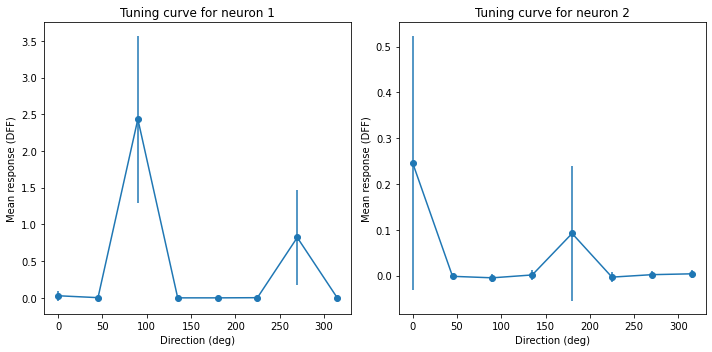

In [32]:
# tuning curve
fig, axs = plt.subplots(1,2, figsize=(10,5))

ax = axs[0]
ax.set_title('Tuning curve for neuron 1')
ax.errorbar(orivals, tuning_tf2, yerr=tuning_std_tf2, fmt='o-')
ax.set_xlabel("Direction (deg)")
ax.set_ylabel("Mean response (DFF)")

ax = axs[1]
ax.set_title('Tuning curve for neuron 2')
ax.errorbar(orivals, tuning2_tf2, yerr=tuning2_std_tf2, fmt='o-')
ax.set_xlabel("Direction (deg)")
ax.set_ylabel("Mean response (DFF)")

fig.tight_layout()

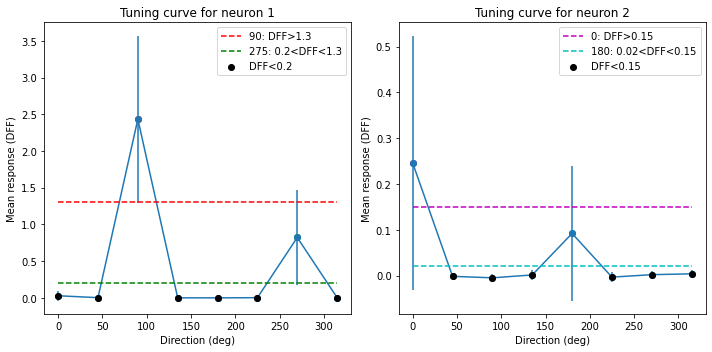

In [35]:
# decode with tuning curves
fig, axs = plt.subplots(1,2, figsize=(10,5))

ax = axs[0]
ax.set_title('Tuning curve for neuron 1')
ax.errorbar(orivals, tuning_tf2, yerr=tuning_std_tf2, fmt='o-')
ax.scatter(orivals[2], tuning_tf2[2], color='r')
ax.hlines([1.3], 0,315, ls='--', color='r', 
           label='90: DFF>1.3', zorder=15)
ax.scatter(orivals[6], tuning_tf2[6], color='g')
ax.hlines([0.2], 0,315, ls='--', color='g', 
           label='275: 0.2<DFF<1.3', zorder=10)
ax.scatter(orivals[[0,1,3,4,5,7]], tuning_tf2[[0,1,3,4,5,7]], color='k',
            label='DFF<0.2', zorder=5)
ax.legend()
ax.set_xlabel("Direction (deg)")
ax.set_ylabel("Mean response (DFF)")


ax = axs[1]
ax.set_title('Tuning curve for neuron 2')
ax.errorbar(orivals, tuning2_tf2, yerr=tuning2_std_tf2, fmt='o-')
ax.scatter(orivals[0], tuning2_tf2[0], color='m')
ax.hlines([0.15], 0,315, ls='--', color='m', 
           label='0: DFF>0.15', zorder=15)
ax.scatter(orivals[4], tuning2_tf2[4], color='c')
ax.hlines([0.02], 0,315, ls='--', color='c', 
           label='180: 0.02<DFF<0.15', zorder=10)
ax.scatter(orivals[[1,2,3,5,6,7]], tuning2_tf2[[1,2,3,5,6,7]], color='k',
            label='DFF<0.15', zorder=5)
ax.legend()
ax.set_xlabel("Direction (deg)")
ax.set_ylabel("Mean response (DFF)")

fig.tight_layout()

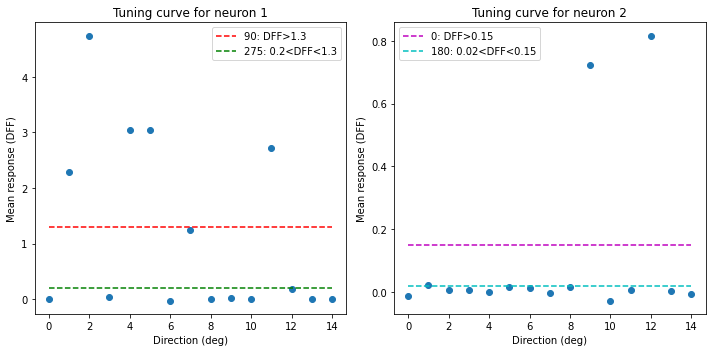

In [41]:
# plot the trial-to-trial response side by side
# decode with tuning curves
fig, axs = plt.subplots(1,2, figsize=(10,5))

ax = axs[0]
ax.set_title('Tuning curve for neuron 1')
ax.scatter(np.arange(15), response.trial_response[:15])
ax.hlines([1.3], 0,14, ls='--', color='r', 
           label='90: DFF>1.3', zorder=15)
ax.hlines([0.2], 0,14, ls='--', color='g', 
           label='275: 0.2<DFF<1.3', zorder=10)
ax.legend()
ax.set_xlabel("Direction (deg)")
ax.set_ylabel("Mean response (DFF)")


ax = axs[1]
ax.set_title('Tuning curve for neuron 2')
ax.scatter(np.arange(15), response2.trial_response[:15])
ax.hlines([0.15], 0,14, ls='--', color='m', 
           label='0: DFF>0.15', zorder=15)
ax.hlines([0.02], 0,14, ls='--', color='c', 
           label='180: 0.02<DFF<0.15', zorder=10)
ax.legend()
ax.set_xlabel("Direction (deg)")
ax.set_ylabel("Mean response (DFF)")

fig.tight_layout()

### What enables us to better decode the simulus orientation when we use two neurons?
- different response selectivity
- more samples trial-to-trial neural response variability

### How can we better visualize the responses of 2 neurons

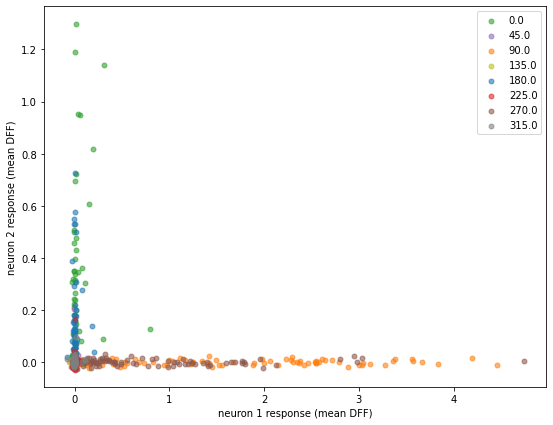

In [43]:
colors = ['tab:green', 'tab:purple', 'tab:orange', 'tab:olive',
          'tab:blue', 'tab:red', 'tab:brown', 'tab:gray']

plt.figure(figsize=(9,7))
for i, ori in enumerate(orivals):
    ind = stim_table.orientation[stim_table.orientation==ori].index
    plt.scatter(
        response.trial_response[ind].values, 
        response2.trial_response[ind].values,
        c=colors[i],
        s=24, alpha=0.6,
        label=f'{ori}'
    )

plt.xlabel('neuron 1 response (mean DFF)')
plt.ylabel('neuron 2 response (mean DFF)')
plt.legend()

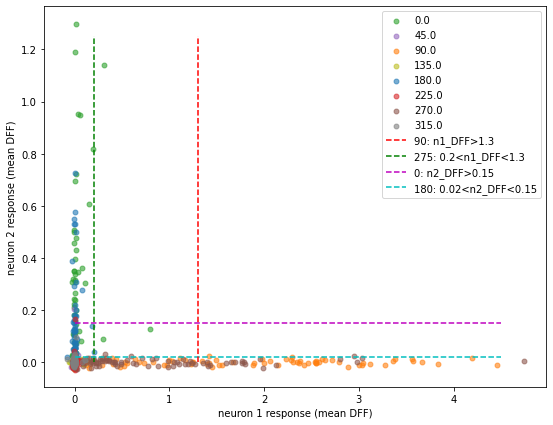

In [47]:
colors = ['tab:green', 'tab:purple', 'tab:orange', 'tab:olive',
          'tab:blue', 'tab:red', 'tab:brown', 'tab:gray']

plt.figure(figsize=(9,7))
for i, ori in enumerate(orivals):
    ind = stim_table.orientation[stim_table.orientation==ori].index
    plt.scatter(
        response.trial_response[ind].values, 
        response2.trial_response[ind].values,
        c=colors[i],
        s=24, alpha=0.6,
        label=f'{ori}'
    )

# decision boundaries
plt.vlines([1.3], 0,1.25, ls='--', color='r', 
           label='90: n1_DFF>1.3', zorder=15)
plt.vlines([0.2], 0,1.25, ls='--', color='g', 
           label='275: 0.2<n1_DFF<1.3', zorder=10)
plt.hlines([0.15], 0,4.5, ls='--', color='m', 
           label='0: n2_DFF>0.15', zorder=15)
plt.hlines([0.02], 0,4.5, ls='--', color='c', 
           label='180: 0.02<n2_DFF<0.15', zorder=10)

plt.xlabel('neuron 1 response (mean DFF)')
plt.ylabel('neuron 2 response (mean DFF)')
plt.legend()

In [52]:
# heuristic decoding using cell1 tuning profile
import random

ori_heuristic_2cells = []
for trial_response, trial_response2 in zip(response_tf2.trial_response, response2_tf2.trial_response):
    if trial_response >= 1.3:
        ori_heuristic_2cells.append(90)
    elif (trial_response < 1.3 and trial_response>=0.2):
        ori_heuristic_2cells.append(270)
    elif trial_response2 > 0.15:
        ori_heuristic_2cells.append(0)
    elif (trial_response2 < 0.15 and trial_response2 > 0.02):
        ori_heuristic_2cells.append(180)
    else:
        ori_heuristic_2cells.append(random.choice([45, 135, 225, 315]))

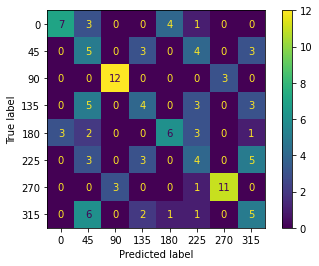

In [53]:
# confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(stim_table[stim_table.temporal_frequency==2.0].orientation.fillna(0).astype(int), ori_heuristic_2cells)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, 
                              display_labels=np.arange(0, 360, 45))
disp.plot()

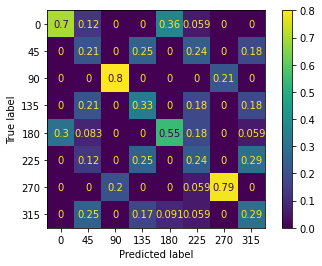

In [54]:
# normalized confusion matrix
normalized_cm = cm/ np.sum(cm, axis=0)
disp = ConfusionMatrixDisplay(confusion_matrix=normalized_cm, 
                              display_labels=np.arange(0, 360, 45))
disp.plot()

[Discuss] Compare this confusion matrix with the previous one using only cell1. What's the difference? Which one gives better decodability of direction? What does this tell us?

### What does the above plot tell us how to decode the stimulus orientation from the responses of 2 neurons?

### What does this imply if we use even more neurons to decode?

# Archive

### if review of data access not needed

In [ ]:
cell1_id = 541513979
# cell2_id = 541513083

exps = boc.get_ophys_experiments(cell_specimen_ids=[cell1_id], stimuli=['drifting_gratings'])
session_id = exps[0]['id']
data_set = boc.get_ophys_experiment_data(session_id)

cell1 = data_set.get_cell_specimen_indices([cell1_id])[0]

dg = DriftingGratings(data_set)
mean_sweep_response = dg.mean_sweep_response

In [ ]:
mean_sweep_response.head()

,0,1,2,3,4,5,6,7,8,9,...,281,282,283,284,285,286,287,288,289,dx
0,6.891243,7.517585,2.343453,5.529656,3.089913,1.686330,-1.367414,-9.263052,1.762542,-4.388489,...,0.398421,4.372705,3.260812,-2.490010,6.776690,6.982275,-1.518821,8.620127,-0.961270,0.176110
1,10.591821,-2.456462,4.431817,6.015740,2.329124,4.481802,214.028275,0.711353,3.727799,4.574836,...,4.051547,5.474393,15.743465,4.501874,1.825517,6.921224,-0.794951,1.684151,1.619171,-0.004938
2,-4.592984,0.944791,-2.644932,-0.738181,2.530743,0.066425,163.345535,-5.243430,-1.886712,-1.378778,...,-0.062635,-9.895056,-1.297758,-0.040308,1.037433,10.763675,0.584554,-0.095751,-2.810576,0.014611
3,0.263614,0.792297,0.900663,-3.191322,1.586282,3.359579,-55.824673,5.669029,1.453363,2.468270,...,2.700351,4.502042,8.352746,5.014870,0.564478,-1.811354,0.218400,-0.769772,5.604090,-0.001725
4,0.170324,-0.564040,-0.325393,-0.598044,0.931561,0.215377,311.882935,-2.973898,-2.242919,-3.969306,...,-0.776091,-3.384682,2.066027,-3.075355,0.639545,-0.084199,-2.117842,-0.666240,-2.607536,-0.002175


In [ ]:
mean_response_cell1 = mean_sweep_response[f'{cell1}']
mean_response_cell1.head()

0     -1.367414
1    214.028275
2    163.345535
3    -55.824673
4    311.882935
Name: 6, dtype: float32

In [ ]:
dg.stim_table.head()

,temporal_frequency,orientation,blank_sweep,start,end
0,1.0,45.0,0.0,736,796
1,15.0,90.0,0.0,826,886
2,1.0,270.0,0.0,917,977
3,0.0,0.0,1.0,1007,1067
4,4.0,90.0,0.0,1098,1158


In [ ]:
# Use the information in the stimulus table to select a subset of responses at a particular temporal frequency
# Drop the running speed column also, as before
selected_sweeps = (dg.stim_table['temporal_frequency'] == 2.0)
selected_responses = mean_sweep_response[selected_sweeps].drop(columns=['dx'])

In [ ]:
# plot grating response as a function of the grating orientation
plt.plot(response.orientation.values, response.trial_response.values, 'o')
plt.xticks(range(0,360,45))
plt.xlim(-10,325)
plt.xlabel("Direction", fontsize=16)
plt.ylabel("Mean DF/F", fontsize=16)

In [ ]:
# tuning curve
all_ori = np.sort(stim_table.orientation.unique())
orivals = all_ori[np.isfinite(all_ori)]
print(orivals)

# compute
tuning = np.empty((8))
tuning_std = np.empty((8))
for i, ori in enumerate(orivals):
    trials = response[response.orientation==ori]
    tuning[i] = trials.trial_response.mean()
    tuning_std[i] = trials.trial_response.std()
    

# plot
# plt.plot(orivals, tuning, 'o-')
plt.errorbar(orivals, tuning, yerr=tuning_std, fmt='o-')
plt.xlabel("Direction (deg)")
plt.ylabel("Mean response (DFF)")

## neuron 2

In [ ]:
# note the above cell is index 6
# same tuning as 6: 44, 56
dff_trace_neuron2 = dff[51, :]  # current best
# 51: 45, 225
# 69: 0, 180
# dff_trace_neuron2 = dff[75, :]

# create a pandas DataFrame to hold the response of the neuron in each trial
response_neuron2 = pd.DataFrame(
    columns=('orientation', 'temporal_frequency', 'trial_response'), 
    index=stim_table.index.values
) 
response_neuron2['orientation'] = stim_table.orientation
response_neuron2['temporal_frequency'] = stim_table.temporal_frequency
for ind,row_stim in stim_table.iterrows():
    response_neuron2.loc[ind, 'trial_response'] = dff_trace_neuron2[int(row_stim.start):int(row_stim.end)].mean()


Text(0, 0.5, 'Mean DFF (%)')

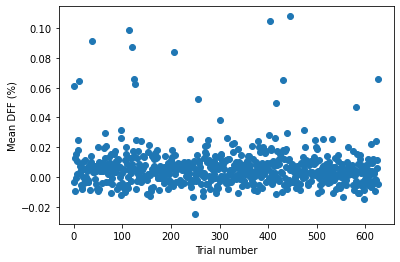

In [ ]:
# Plot the trial_response for all trials
plt.plot(response_neuron2.trial_response, 'o')
plt.xlabel("Trial number")
plt.ylabel("Mean DFF (%)")

Text(0, 0.5, 'Mean DF/F')

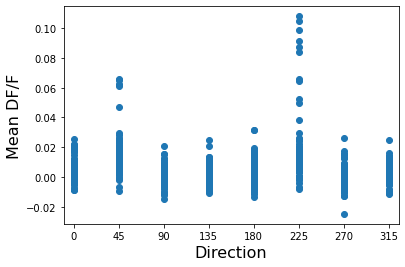

In [ ]:
# plot grating response as a function of the grating orientation
plt.plot(response_neuron2.orientation.values, response_neuron2.trial_response.values, 'o')
plt.xticks(range(0,360,45))
plt.xlim(-10,325)
plt.xlabel("Direction", fontsize=16)
plt.ylabel("Mean DF/F", fontsize=16)

[  0.  45.  90. 135. 180. 225. 270. 315.]


Text(0, 0.5, 'Mean response (DFF)')

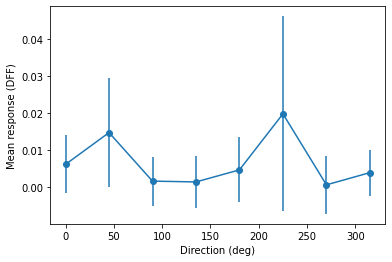

In [ ]:
# tuning curve
all_ori = np.sort(stim_table.orientation.unique())
orivals = all_ori[np.isfinite(all_ori)]
print(orivals)

# compute
tuning_neuron2 = np.empty((8))
tuning_std_neuron2 = np.empty((8))
for i, ori in enumerate(orivals):
    trials = response_neuron2[response.orientation==ori]
    tuning_neuron2[i] = trials.trial_response.mean()
    tuning_std_neuron2[i] = trials.trial_response.std()
    

# plot
# plt.plot(orivals, tuning, 'o-')
plt.errorbar(orivals, tuning_neuron2, yerr=tuning_std_neuron2, fmt='o-')
plt.xlabel("Direction (deg)")
plt.ylabel("Mean response (DFF)")